<a href="https://colab.research.google.com/github/intimanjunath/Neural-network-using-numpy-keras-pytorch-and-jax/blob/main/3_PyTorch_neural_network_builtin_modules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

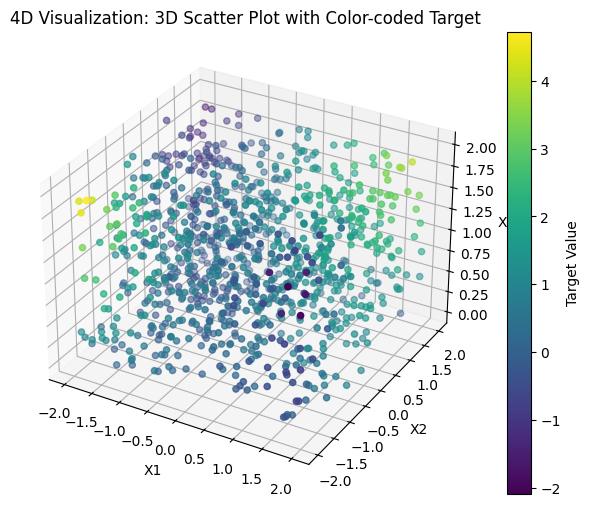

In [1]:
#Generate Synthetic Data & 4D Visualization
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plots

# Define a non-linear function with three variables
def nonlinear_func(x, y, z):
    # Function: sin(x)*cos(y) + log(z + 1) + 0.5*x*y*z
    return torch.sin(x) * torch.cos(y) + torch.log(z + 1) + 0.5 * x * y * z

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
num_samples = 1000

# Generate synthetic data using uniform distributions
X1 = torch.empty(num_samples, 1).uniform_(-2, 2)    # Variable X1 in [-2, 2]
X2 = torch.empty(num_samples, 1).uniform_(-2, 2)    # Variable X2 in [-2, 2]
X3 = torch.empty(num_samples, 1).uniform_(0, 2)     # Variable X3 in [0, 2] for log stability

# Compute target values using the non-linear function
y = nonlinear_func(X1, X2, X3)

# Convert tensors to NumPy arrays for visualization
X1_np = X1.numpy()
X2_np = X2.numpy()
X3_np = X3.numpy()
y_np  = y.numpy()

# 4D Plot: 3D scatter plot with color mapping to the target value
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X1_np, X2_np, X3_np, c=y_np, cmap='viridis')
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
plt.colorbar(sc, label="Target Value")
plt.title("4D Visualization: 3D Scatter Plot with Color-coded Target")
plt.show()

In [2]:
#Data Preprocessing: Normalization & Train/Test Split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Stack the inputs into a single array (shape: num_samples x 3)
features = torch.cat((X1, X2, X3), dim=1).numpy()
target_np = y.numpy()

# Normalize features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target   = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled   = scaler_target.fit_transform(target_np)

# Convert normalized data back to PyTorch tensors
features_scaled = torch.tensor(features_scaled, dtype=torch.float32)
target_scaled   = torch.tensor(target_scaled, dtype=torch.float32)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled,
                                                     test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: torch.Size([800, 3]) torch.Size([800, 1])
Testing set shape: torch.Size([200, 3]) torch.Size([200, 1])


* PyTorch Model Using Built-in Modules

We create a class-based neural network model (inheriting from torch.nn.Module) that consists of three layers:

Input → Hidden Layer 1 (10 neurons)
Hidden Layer 1 → Hidden Layer 2 (8 neurons)
Hidden Layer 2 → Output Layer (1 neuron)
ReLU activation is applied after the first two linear layers.

In [3]:
import torch.nn as nn

class ThreeLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ThreeLayerNN, self).__init__()
        # Define layers using built-in modules
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.out = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.out(x)  # No activation on output (linear regression)
        return x

# Instantiate the model with desired architecture
input_dim   = 3   # Three input features (X1, X2, X3)
hidden_dim1 = 10  # First hidden layer neurons
hidden_dim2 = 8   # Second hidden layer neurons
output_dim  = 1   # Single output

model = ThreeLayerNN(input_dim, hidden_dim1, hidden_dim2, output_dim)
print(model)

ThreeLayerNN(
  (fc1): Linear(in_features=3, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)


*  Training the Model

We use Mean Squared Error (MSE) as the loss function and the SGD optimizer. The training loop performs a forward pass, computes the loss, backpropagates the gradients (using PyTorch’s autograd), and updates the model parameters.

In [4]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    # Forward pass: compute predicted y by passing X_train to the model
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss_history.append(loss.item())

    # Backward pass and optimization
    optimizer.zero_grad()  # Zero the gradients from previous iteration
    loss.backward()        # Compute gradients via backpropagation
    optimizer.step()       # Update parameters

    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

print(f"Final Training Loss: {loss_history[-1]:.5f}")

Epoch 0, Loss: 0.05374
Epoch 100, Loss: 0.02038
Epoch 200, Loss: 0.02015
Epoch 300, Loss: 0.01994
Epoch 400, Loss: 0.01974
Epoch 500, Loss: 0.01955
Epoch 600, Loss: 0.01936
Epoch 700, Loss: 0.01916
Epoch 800, Loss: 0.01897
Epoch 900, Loss: 0.01877
Final Training Loss: 0.01857


In [5]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f"Test Loss: {test_loss.item():.5f}")

# Convert predictions and targets back to NumPy for comparison and inverse scaling
y_test_np = y_test.numpy()
y_test_pred_np = y_test_pred.numpy()

# Inverse transform the normalized targets to the original scale
y_test_orig      = scaler_target.inverse_transform(y_test_np)
y_test_pred_orig = scaler_target.inverse_transform(y_test_pred_np)

print("\nFirst 5 Test Predictions vs Actual:")
for i in range(5):
    print(f"Predicted: {y_test_pred_orig[i][0]:.4f}, Actual: {y_test_orig[i][0]:.4f}")

Test Loss: 0.02169

First 5 Test Predictions vs Actual:
Predicted: 0.7785, Actual: 1.1071
Predicted: 0.6143, Actual: 1.2131
Predicted: 0.6789, Actual: 1.9714
Predicted: 0.4615, Actual: -0.6978
Predicted: 0.6367, Actual: -0.0541


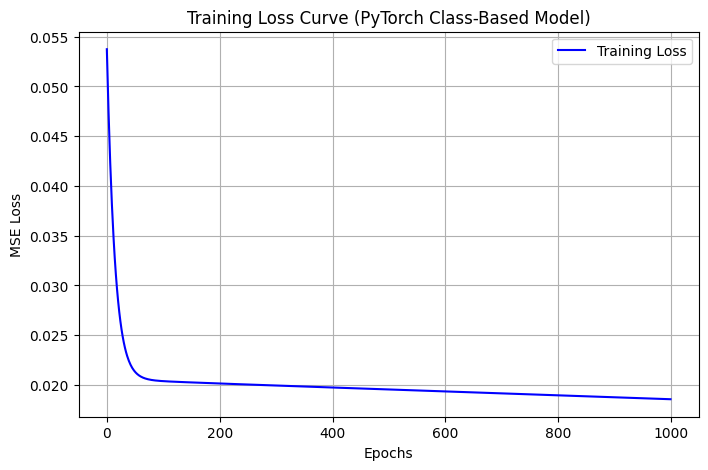

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_history, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve (PyTorch Class-Based Model)")
plt.legend()
plt.grid(True)
plt.show()